In [536]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os
import warnings
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [537]:
warnings.filterwarnings("ignore")

## Load Dataset

In [538]:
path = kagglehub.dataset_download("fedesoriano/cirrhosis-prediction-dataset")

path

'/root/.cache/kagglehub/datasets/fedesoriano/cirrhosis-prediction-dataset/versions/2'

In [539]:
os.listdir(path)[0]

'cirrhosis.csv'

## Data PreProcessing

In [540]:
df = pd.read_csv(f'{path}/{os.listdir(path)[0]}')

df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [541]:
# check for missing values

def missing_values(df):
  missing_values = df[df.columns[1:]].isnull()
  return missing_values.sum(), len(df.columns)

missing_values(df)

(N_Days             0
 Status             0
 Drug             106
 Age                0
 Sex                0
 Ascites          106
 Hepatomegaly     106
 Spiders          106
 Edema              0
 Bilirubin          0
 Cholesterol      134
 Albumin            0
 Copper           108
 Alk_Phos         106
 SGOT             106
 Tryglicerides    136
 Platelets         11
 Prothrombin        2
 Stage              6
 dtype: int64,
 20)

In [542]:
# drop columns with missing values more than threshold

threshold = 0.8 * len(df)

df = df.dropna(thresh = threshold, axis = 1)

df.head()

,ID,N_Days,Status,Age,Sex,Edema,Bilirubin,Albumin,Platelets,Prothrombin,Stage
0,1,400,D,21464,F,Y,14.5,2.60,190.0,12.2,4.0
1,2,4500,C,20617,F,N,1.1,4.14,221.0,10.6,3.0
2,3,1012,D,25594,M,S,1.4,3.48,151.0,12.0,4.0
3,4,1925,D,19994,F,S,1.8,2.54,183.0,10.3,4.0
4,5,1504,CL,13918,F,N,3.4,3.53,136.0,10.9,3.0


In [543]:
missing_values(df)

(N_Days          0
 Status          0
 Age             0
 Sex             0
 Edema           0
 Bilirubin       0
 Albumin         0
 Platelets      11
 Prothrombin     2
 Stage           6
 dtype: int64,
 11)

In [544]:
# fill missing values

df['Platelets'] = df['Platelets'].fillna(df['Platelets'].median())
df['Prothrombin'] = df['Prothrombin'].fillna(df['Prothrombin'].mean())
df['Stage'] = df['Stage'].fillna(df['Stage'].median())

missing_values(df)

(N_Days         0
 Status         0
 Age            0
 Sex            0
 Edema          0
 Bilirubin      0
 Albumin        0
 Platelets      0
 Prothrombin    0
 Stage          0
 dtype: int64,
 11)

In [545]:
print(df['Sex'].unique())
print(df['Edema'].unique())
print(df['Status'].unique())

['F' 'M']
['Y' 'N' 'S']
['D' 'C' 'CL']


In [546]:
# converting str values in int

df['Sex'] = df['Sex'].map({'M': 0, 'F': 1})
df['Edema'] = df['Edema'].map({'N': 0, 'Y': 1, 'S': 0})
df['Status'] = df['Status'].map({'D': 0, 'C': 1, 'CL': 2})

df.head()

,ID,N_Days,Status,Age,Sex,Edema,Bilirubin,Albumin,Platelets,Prothrombin,Stage
0,1,400,0,21464,1,1,14.5,2.60,190.0,12.2,4.0
1,2,4500,1,20617,1,0,1.1,4.14,221.0,10.6,3.0
2,3,1012,0,25594,0,0,1.4,3.48,151.0,12.0,4.0
3,4,1925,0,19994,1,0,1.8,2.54,183.0,10.3,4.0
4,5,1504,2,13918,1,0,3.4,3.53,136.0,10.9,3.0


In [547]:
df = df.drop('ID', axis = 1)

df.head()

,N_Days,Status,Age,Sex,Edema,Bilirubin,Albumin,Platelets,Prothrombin,Stage
0,400,0,21464,1,1,14.5,2.60,190.0,12.2,4.0
1,4500,1,20617,1,0,1.1,4.14,221.0,10.6,3.0
2,1012,0,25594,0,0,1.4,3.48,151.0,12.0,4.0
3,1925,0,19994,1,0,1.8,2.54,183.0,10.3,4.0
4,1504,2,13918,1,0,3.4,3.53,136.0,10.9,3.0


In [548]:
print(f"We have to classify the data in {len(df['Stage'].unique())} classes ==> {df['Stage'].unique()}")

We have to classify the data in 4 classes ==> [4. 3. 2. 1.]


## Data Scaling

In [549]:
# function to apply standard scaler
def standard_scaler(df):

  new_df = pd.DataFrame()

  for c in df.columns:
    if c == 'Stage':
      new_df[c] = df[c]
      continue
    mean = df[c].mean()
    std = df[c].std()
    new_df[c] = (df[c] - mean) / std

  return new_df

df = standard_scaler(df)

## Split and Convert Data

In [550]:
# split the data in test train
X = df.drop(['Stage'], axis=1)
y = df['Stage']

# y_train and y_test labels must start from 0
y = y - y.min()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [551]:
# convert data to tensors
X_train = torch.from_numpy(X_train.values).type(torch.float)
X_test = torch.from_numpy(X_test.values).type(torch.float)
y_train = torch.from_numpy(y_train.values).type(torch.LongTensor)
y_test = torch.from_numpy(y_test.values).type(torch.LongTensor)

In [552]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([334, 9]),
 torch.Size([84, 9]),
 torch.Size([334]),
 torch.Size([84]))

In [553]:
torch.unique(y_train)

tensor([0, 1, 2, 3])

## Creating the Neural Network

In [554]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [555]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [556]:
# accuracy function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [557]:
# define the model
class MyModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [558]:
my_model = MyModel(input_features=X_train.shape[1], output_features= len(torch.unique(y_train)), hidden_units=12).to(device)
my_model

MyModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=9, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=4, bias=True)
  )
)

In [559]:
# loss function
loss_fn = nn.CrossEntropyLoss()

In [560]:
# optimizer
optimizer = torch.optim.SGD(params=my_model.parameters(), lr=0.03)

In [561]:
epochs = 25000

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
epoch_list = []

torch.random.manual_seed(42)

for epoch in range(1,epochs+1):
  my_model.train()

  y_logits = my_model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  my_model.eval()

  with torch.inference_mode():
    test_logits = my_model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,y_test)
    test_accuracy = accuracy_fn(y_test, test_pred)

  if epoch % 100 == 0:
    epoch_list.append(epoch)
    train_loss_list.append(loss)
    train_acc_list.append(acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_accuracy)

  if epoch % 500 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.2f}%")

Epoch: 500 | Loss: 1.08581 | Accuracy: 51.50% | Test Loss: 1.08758 | Test Accuracy: 53.57%
Epoch: 1000 | Loss: 1.05425 | Accuracy: 53.59% | Test Loss: 1.10736 | Test Accuracy: 52.38%
Epoch: 1500 | Loss: 1.02797 | Accuracy: 56.29% | Test Loss: 1.12352 | Test Accuracy: 51.19%
Epoch: 2000 | Loss: 0.99962 | Accuracy: 57.49% | Test Loss: 1.14397 | Test Accuracy: 51.19%
Epoch: 2500 | Loss: 0.96327 | Accuracy: 61.68% | Test Loss: 1.17642 | Test Accuracy: 50.00%
Epoch: 3000 | Loss: 0.93015 | Accuracy: 63.77% | Test Loss: 1.21985 | Test Accuracy: 47.62%
Epoch: 3500 | Loss: 0.90600 | Accuracy: 64.97% | Test Loss: 1.27104 | Test Accuracy: 50.00%
Epoch: 4000 | Loss: 0.88785 | Accuracy: 63.77% | Test Loss: 1.30219 | Test Accuracy: 51.19%
Epoch: 4500 | Loss: 0.86909 | Accuracy: 64.37% | Test Loss: 1.31758 | Test Accuracy: 51.19%
Epoch: 5000 | Loss: 0.85131 | Accuracy: 64.67% | Test Loss: 1.34911 | Test Accuracy: 50.00%
Epoch: 5500 | Loss: 0.83519 | Accuracy: 65.57% | Test Loss: 1.38260 | Test Accura

## Conclusion: The Data is overfitting on Train Data

In [562]:
# Convert the recorded lists to numerical values if they are tensors
train_loss_list = [loss.item() if torch.is_tensor(loss) else loss for loss in train_loss_list]
test_loss_list = [loss.item() if torch.is_tensor(loss) else loss for loss in test_loss_list]

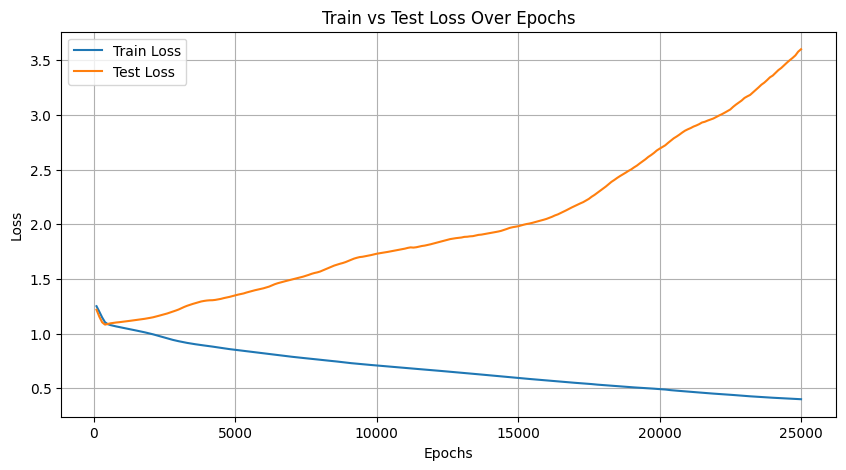

In [563]:
# Plot training vs test loss
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, train_loss_list, label="Train Loss", linestyle="-")
plt.plot(epoch_list, test_loss_list, label="Test Loss", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

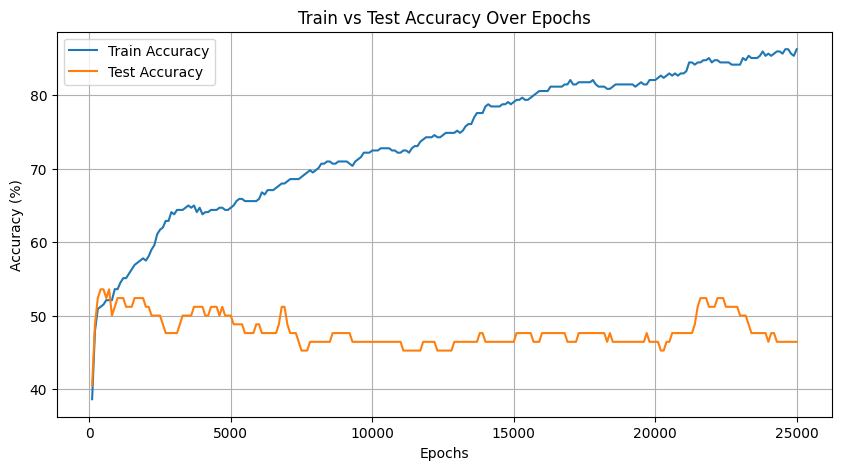

In [564]:
# Plot training vs test accuracy
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, train_acc_list, label="Train Accuracy", linestyle="-")
plt.plot(epoch_list, test_acc_list, label="Test Accuracy", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()